## Run FUTURES POTENTIAL submodel  

#### The POTENTIAL submodel ([r.futures.potential](https://grass.osgeo.org/grass82/manuals/addons/r.futures.potential.html)) determines site suitability using a set of coefficients and the probability of past development.  

#### Zoning as a predictor in the POTENTIAL submodel
Zoning is a land use policy tool used to restrict the type and intensity of land use throughout the United States. The following Notebook illustrates one way zoning data could be incorporated into the FUTURES urban growth model. 

##### This notebook illustrates three methods for parameterizing the FUTURES POTENTIAL submodel:  

- Base Parameterization: including classic predictors of development (e.g., land cover data, slope, transportation indicators)
- Core District Zoning Parameterization: including classic predictors and core-district zoning
- Sub-District Zoning Parameterization: including classic predictors and sub-district zoning

Core district zoning includes three zoning districts (residential, non-residential, and mixed-use)  

Sub-district zoning includes 13 zoning districts (open space, industrial, commercial, office, planned use, high-density residential, medium-high-density residential, medium-density residential, medium-low-density residential, low-density residential, agricultural residential, mixed use, and downtown). A subset of sub-districts was utilized for parameterization. See cell 20.

###### Usage note: this script relies on output from FUTURES_preprocessing.ipynb

Initialize GRASS notebook and add required extensions

In [1]:
# Set up GRASS environment
import os
from IPython.display import Image
from helper import show_interactively, show
import grass.script as gs
import csv
# had to add shell = True to helper.py for this to work
from helper import initialize_GRASS_notebook
initialize_GRASS_notebook(binary='grass83',
                          grassdata="D:\\grassdata", location="FUTURES_zoning_prelim",
                          mapset="input")

Set GRASS region and mask to the Central Pines Regional Council

In [2]:
!g.region vector=central_pines_regional_council@input res=30
!r.mask raster=sa_counties@input

All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.


Set parameters to be used throughout Notebook

In [4]:
# core district zones
core_district = 'dist_to_mixeduse_km,dist_to_nonresidential_km,dist_to_residential_km'
# sub-district zones
sub_district = 'dist_to_downtown_km,dist_to_planned_dev_km,dist_to_commercial_km,dist_to_industrial_km,dist_to_low_den_residential_km,dist_to_high_den_residential_km'
# without zoning
parameters = 'devpressure_2001,slope,road_dens_perc,forest_2001_smooth_perc,ag_2001_smooth_perc,dist_to_water_2001_km,dist_to_wetland_2001_km,dist_to_protected_km,dist_to_city_boundaries_km'
# with zoning - core
core_parameters = ",".join([parameters, core_district])
# with zoning - sub
sub_parameters = ",".join([parameters, sub_district])
# with core and sub zoning districts
all_parameters = ",".join([parameters, core_district, sub_district])
# development change raster
developed = 'urban_change_01_11'
# subregions
subregion = 'sa_counties'

Define function to return list of predictors selected from POTENTIAL model

In [5]:
def get_pred(file_name):
    file = open(file_name)
    csvreader = csv.reader(file)
    pred = []
    pred = next(csvreader)
    file.close()
    return pred

Define function to call POTENTIAL submodel in GRASS GIS

In [6]:
def potential(potential_file, parameters, nprocs):
    gs.run_command('r.futures.potential', flags='d', input='sampling', nprocs=nprocs,
                output=potential_file, columns=parameters, random_column = 'devpressure_2001',
                developed_column=developed, subregions_column=subregion, min_variables=6)
    return(get_pred(potential_file))

Define function to print map of development potential

In [6]:
def potential_surface(potential_file, output):
    gs.run_command('r.futures.potsurface', input=potential_file, subregions=subregion, output=output)
    gs.run_command('r.colors', map=output, color='byr')
    return(show(output))

### Base Parameterization of the POTENTIAL submodel  

Utilizing the dredge function to select the optimal parameterization of the POTENTIAL model without zoning resulted  
in the selection of agricultural land, distance to city boundaries, distance to protect area, forest location,  
road density, and slope as the influential parameters on development potential.

In [7]:
# returns chosen predictors
potential('results\\potential.csv', parameters, 5)

['ID',
 'Intercept',
 'devpressure_30_05_01_2001',
 'ag_2001_smooth_perc',
 'dist_to_city_boundaries_km',
 'dist_to_protected_km',
 'forest_2001_smooth_perc',
 'road_dens_perc',
 'slope']

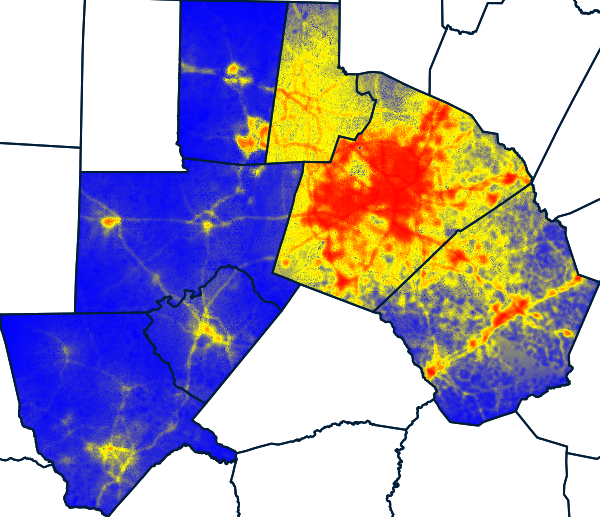

In [7]:
# explore potential surface if interested -- not necessary step
potential_surface('results\\potential.csv', 'suitability')

### Core District Zoning Parameterization of the POTENTIAL submodel

Utilizing the dredge function to select the optimal parameterization of the POTENTIAL model with core district zoning   
resulted in the selection of agricultural land, distance to mixed use zoning, distance to non-residential zoning,  
distance to water, road density, and slope as the influential parameters on development potential.

In [8]:
potential('results\\potential_core.csv', core_parameters, 5)

['ID',
 'Intercept',
 'devpressure_30_05_01_2001',
 'ag_2001_smooth_perc',
 'dist_to_mixeduse_km',
 'dist_to_nonresidential_km',
 'dist_to_water_2001_km',
 'road_dens_perc',
 'slope']

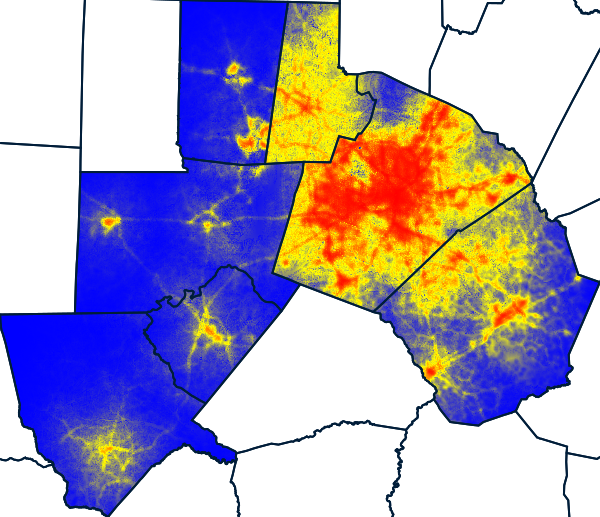

In [8]:
potential_surface('results\\potential_core.csv', 'suitability_core')

### Sub-District Zoning Parameterization of the POTENTIAL submodel

Originally, the sub-district zoning included 13 unique districts. However, for the purposes of FUTURES parameterization certain sub-districts were combined. For example, six residential density classes were combined into two classes (high density and low density).

Utilizing the dredge function to select the optimal parameterization of the POTENTIAL model with sub-district zoning resulted in the selection of agricultural land, distance to city boundaries, distance to commercial, distance to planned development, distance to water, road density, and slope as the influential parameters on development potential.

In [9]:
potential('results\\potential_sub.csv', sub_parameters, 6)

['ID',
 'Intercept',
 'devpressure_30_05_01_2001',
 'ag_2001_smooth_perc',
 'dist_to_city_boundaries_km',
 'dist_to_commercial_km',
 'dist_to_planned_dev_km',
 'dist_to_water_2001_km',
 'road_dens_perc',
 'slope']

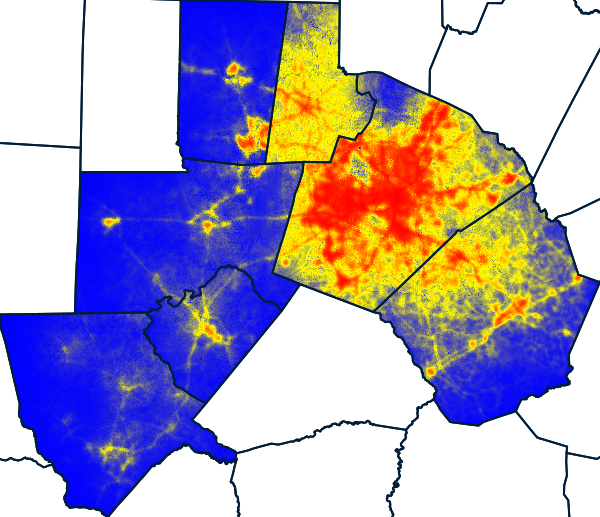

In [9]:
potential_surface('results\\potential_sub.csv', 'suitability_sub')

## Discussion of POTENTIAL Submodel Results

### POTENTIAL Parameterization  

Agricultural land, road density, and slope were the only parameters chosen across all models. distance to city boundaries was selected under the baseline and sub-district parameterizations and distance to water was selected for the core-district and sub-district zoning parameterizations. For the core district model, distance to mixed use and distance to non-residential were selected while distance to residential was not (this is unsurprising given that roughly 85% of the landscape is zoning residential). For the sub-district model, only distance to commercial and distance to planned development were selected. Distance to planned development is intuitive, however I need to further explore the relationship between zoning and development to understand why distance to commercial was selected over other classes such has high-density residential or downtown.

### Suitability Surfaces  

Across all suitability surfaces, Wake County remains a constant source of large amounts of suitable surface and the pattern varies little across each layer. However, we see some variabilty in suitabilty of land in other (more rural) counties surrounding Wake County. For example, for the base and sub-district parameterizations, we see more suitable land in the small municipalities in Moore County (most southern and western county in study area) while in the core-district parameterization we see much larger suitability spreading from Pinehurst but no other suitable land throughout the County. For the sub-district parameterization there is greater centralization of suitable land and less sprawling suitability far from urban centers as is seen in the other parameterizations. In general, we see the greatest sprawling suitabilty in the core district parameterization, a median amount in the baseline, and the least in the sub-district parameterization.